In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

# Reflect Tables into SQLAlchemy ORM

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Total number of dates
session.query(func.count(Measurement.date)).all()

[(19550)]

In [12]:
# First and Last dates with data point in the database
results = session.query(Measurement.date).order_by(Measurement.date.desc()).all()
last_valuation = results[0]
first_valuation = results[-1]

In [13]:
first_valuation

('2010-01-01')

In [14]:
last_valuation

('2017-08-23')

In [15]:
# Perform a query to retrieve the data and precipitation scorehs for the last 12 monts
results_last_year = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= '2016-08-23').\
    filter(Measurement.date <= '2017-08-23').all()
    
#results_last_year

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results_last_year, columns=['date', 'prcp'])
df = df.sort_values('date')
df.set_index('date', inplace=True)
df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


In [17]:
# Count number of rows dataset
len(df)

2230

In [18]:
# Rename column
df.columns = ['precipitation'] 

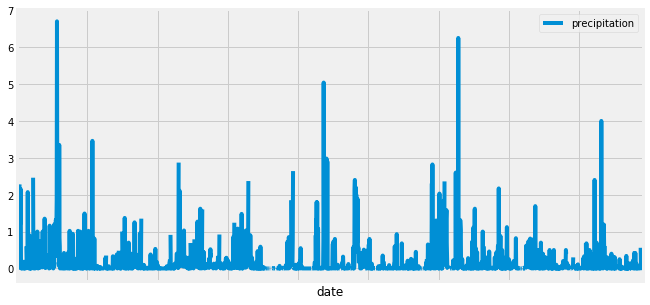

In [19]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(kind="line", y="precipitation", figsize=(10, 5), grid=True)
ax = plt.axes()
plt.setp(ax.get_xticklabels(), visible=False)
plt.show()

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [21]:
# Design a query to show how many stations are available in this dataset?
#session.query(Measurement).distinct(Measurement.station).group_by(Measurement.station).count()
session.query(func.count(Station.station)).all()

[(9)]

In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
results_most_active = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()
    
results_most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature for most active station?
sel = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]
session.query(*sel).filter(Measurement.station == "USC00519281").all()


[('USC00519281', 54.0, 85.0, 71.66378066378067)]

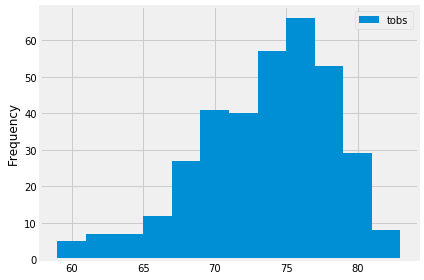

In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results_tobs = session.query(Measurement.tobs).\
    filter(Measurement.station == "USC00519281").\
    filter(Measurement.date >= '2016-08-23').\
    filter(Measurement.date <= '2017-08-23').all()

# Store results in data frame
df_tobs = pd.DataFrame(results_tobs, columns=['tobs'])

# Plot results as a histogram
df_tobs.plot.hist(bins=12)
plt.tight_layout()
plt.show()

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
import datetime as dt

# my trip dates are '2018-05-01' to '2018-05-07'
# previous year dates are '2017-05-01' to '2017-05-07'

prev_year_start = dt.date(2017, 5, 1) - dt.timedelta(days=365)
prev_year_end = dt.date(2017, 5, 7) - dt.timedelta(days=365)

tmin, tavg, tmax = calc_temps(prev_year_start.strftime("%Y-%m-%d"), prev_year_end.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

66.0 73.81818181818181 79.0


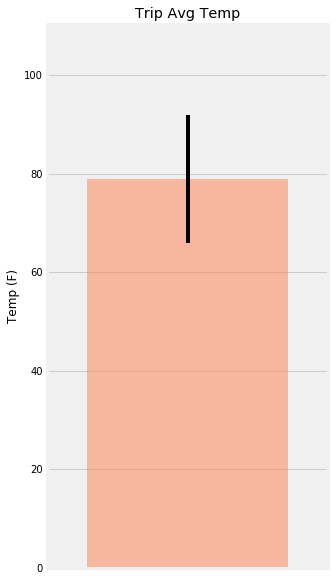

In [27]:
# Build the plot
x_pos = 1
yerr = tmax - tmin

fig, ax = plt.subplots(figsize=(4.5,10))
ax.bar(x_pos, tmax, yerr=yerr, alpha=0.5, color="coral", align="center")
ax.set_ylabel("Temp (F)")
ax.set_xticks(range(x_pos))
ax.set_title("Trip Avg Temp")
ax.margins(.2, .2)
plt.show()

In [28]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = '2012-01-01'
end_date = '2012-01-07'

sel = [Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

results_prcp = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
    
print(results_prcp)


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [30]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start = '2018-05-01'
trip_end = '2018-05-07'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(start=trip_start, end=trip_end)

#trip_dates

# Stip off the year and save a list of %m-%d strings
trip_month_day = trip_dates.strftime('%m-%d')

#trip_month_day

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in trip_month_day:
    normals.append(*daily_normals(date))
    
normals

[(65.0, 72.75925925925925, 79.0),
 (65.0, 73.05084745762711, 79.0),
 (67.0, 73.41071428571429, 84.0),
 (65.0, 73.59649122807018, 78.0),
 (67.0, 73.39655172413794, 79.0),
 (66.0, 73.14035087719299, 80.0),
 (64.0, 71.78846153846153, 79.0)]

In [31]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_trip = pd.DataFrame(normals, columns=['tmin','tavg','tmax'])
df_trip['date'] = trip_dates
df_trip.set_index(['date'], inplace=True)
df_trip.head()

,tmin,tavg,tmax
date,,,
2018-05-01,65.0,72.759259,79.0
2018-05-02,65.0,73.050847,79.0
2018-05-03,67.0,73.410714,84.0
2018-05-04,65.0,73.596491,78.0
2018-05-05,67.0,73.396552,79.0


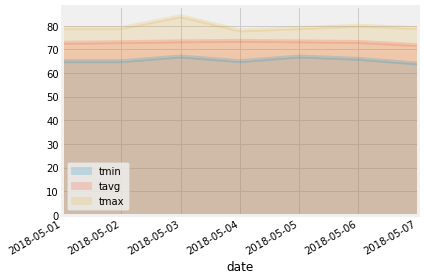

In [32]:
# Plot the daily normals as an area plot with `stacked=False`
df_trip.plot(kind='area', stacked=False, x_compat=True, alpha=.2)
plt.tight_layout()